<a href="https://colab.research.google.com/github/simran-padam/LSTM-Multivariate-Time-Series/blob/main/LSTM_Multivariate_Time_Series_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. IMPORT LIBRARIES**

In [39]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
import tensorflow as tf

pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)

def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn

**2. IMPORT TRAIN & TEST SET**

In [40]:
train_path = "/content/drive/MyDrive/Colab Notebooks/train_data.xlsx"
test_path = "/content/drive/MyDrive/Colab Notebooks/test_data.xlsx"
train_data = pd.read_excel(train_path, sheet_name = "Model Dataset Train")
test_data = pd.read_excel(test_path, sheet_name = "Test")
print("train_data:",train_data.shape)
print("test_data:",test_data.shape)

train_data: (144, 131)
test_data: (12, 131)


**3. EXPLORATORY ANALYSIS**

In [41]:
categorical_cols = train_data.select_dtypes('object').columns.to_list()
numeric_cols = train_data.select_dtypes('number').columns.to_list()
print("The categorical columns are : ",len(categorical_cols))
print("The numerical columns are : ", len(numeric_cols))

The categorical columns are :  0
The numerical columns are :  130


In [42]:
print("train_data time period:", min(train_data["WEEK_START_DATE"]), "to", max(train_data["WEEK_START_DATE"])), 
print("test_data time period:",min(test_data["WEEK_START_DATE"]),"to", max(test_data["WEEK_START_DATE"]))

train_data time period: 2017-08-27 00:00:00 to 2020-05-31 00:00:00
test_data time period: 2020-06-07 00:00:00 to 2020-08-23 00:00:00


In [43]:
train_data.head()

,FISCAL_YEAR,FISCAL_WEEK,WEEK_START_DATE,FISCAL_QUARTER,TOTAL_RETAIL,CSAT_Total,CSAT_5,CSAT_5_Point_Rate,LA_PROJ_HOURS,LA_AUTOZONERS,LA_TRUCK_HOURS,LA_TASK_HOURS,SUM_SCAN_COUNT,max_temp,min_temp,avg_temp,max_prcp,sum_snow,max_wspd,Email_Delivered,EM_campaign_count,DM_campaign_count,DM_Circulation,SMS_Offer_count,SMS_dollaroff_offer_count,SMS_percentoff_offer_count,SMS_Circulation,Ecomm_offer_count,Ecomm_dollaroff_offer_count,Ecomm_percentoff_offer_count,Ecomm_FS_only_offer_count,Web_Traffic,Oil_Recycling,OKV,TLV,AZ_store_count,AUTOZONE_ALL,AUTOZONE_Mobile,Advance_ALL,Oreilly_ALL,Napaonline_ALL,Pepboys_ALL,CarQuest_ALL,Advance_Mobile,Oreilly_Mobile,Pepboys_Mobile,Napaonline_Mobile,Signage,Print_Circulars,num_competitor_store,Total_Vehicle_Sales,Heavy_Weight_Sales,Light_Weight_Sales,Moving12Month_Vehicle_Miles,Vehicle_Miles,CrudeOilPrices_WTI,CrudeOilPrices_Brent,UnemploymentRate,CPI_Consumers,CPI_Earners_Workers,Retail_FoodServices_Sales,US_30yr_FRM,GDP,fed_funds_rate,DJIA_Open,DJIA_High,DJIA_Low,DJIA_Close,DJIA_Adj_Close,DJIA_Volume,DJIA_Range,NASDAQ_Open,NASDAQ_High,NASDAQ_Low,NASDAQ_Close,NASDAQ_Adj_Close,NASDAQ_Volume,NASDAQ_Range,TV_Spend,Radio_Spend,Search_Spend,Others_Spend,BASE_EARNED_NUM,BASE_EARNED_AMT,BONUS_EARNED_NUM,BONUS_EARNED_AMT,ACTIVE_CUSTOMER_NUM,ACTIVE_LOYAL_CUSTOMER_PCT,NEW_CUSTOMER_PCT,ELITE_CUSTOMER_PCT,AMT,LOYALTY_AMT_PCT,ELITE_AMT_PCT,AutoZone_Trend,Handheld_Cnt,Loan_a_Tool,Charger_Cnt,AutoZone_Trend.1,new_case_count,new_death_count,gps_retail_and_recreation,gps_grocery_and_pharmacy,gps_parks,gps_transit_stations,gps_workplaces,gps_residential,gps_away_from_home,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,initclaims_count_regular,contclaims_count_regular,initclaims_count_pua,contclaims_count_pua,contclaims_count_peuc,initclaims_rate_regular,contclaims_rate_regular,initclaims_rate_pua,contclaims_rate_pua,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,initclaims_rate_combined,contclaims_rate_combined
0,2018,1,2017-08-27,1,153746313.6,16048,11465,0.714419,1421365.93,1162676.25,81648.70,177040.98,239103,119.0,30.9,73.695477,26.03,0.0,67,6457405,32,3,0,1,1,0,189307,7,0,7,0,4229486,1035387,192084475,275261365,15373,7124,4974,2579,2783,838,1001,91,1480,1635,456,255,456386.67,111500.00,8459,17.014,0.424,16.590,3199710,282558,47.68,52.03,4.4,245.519,239.448,491564,3.86,19617.3,1.16,21832.50000,22038.97070,21673.58008,21987.56055,21987.56055,1321950000,365.390625,6286.009766,6449.649902,6228.729980,6435.330078,6435.330078,8282150000,220.919922,497159.65,672672.08,71666.03,28148.04,0,0,0,0.0,1575409,0.918212,0.117337,0.098990,1.009856e+08,0.886216,0.148122,23,318053,76028,64498,23,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
1,2018,2,2017-09-03,1,155898822.5,16048,11465,0.714419,1429560.42,1158595.50,79323.43,191641.49,254719,113.4,31.0,71.231313,2.90,0.0,68,6515685,27,3,0,0,0,0,0,7,0,7,0,4205683,918203,192084475,275261365,15373,6555,4431,2911,3025,657,1941,126,1834,1904,1527,178,456386.67,111500.00,8459,18.324,0.426,17.898,3202883,265212,46.68,52.25,4.2,246.819,240.939,470724,3.82,19617.3,1.15,21912.36914,21921.08984,21709.63086,21797.78906,21797.78906,1274810000,211.458985,6414.819824,6426.509766,6334.589844,6360.189941,6360.189941,7576920000,91.919922,2810.10,733115.58,196576.44,56514.55,0,0,0,0.0,1588696,0.917590,0.114983,0.098347,1.012665e+08,0.884985,0.145896,22,328730,78265,67448,22,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
2,2018,3,2017-09-10,1,147075783.5,16048,11465,0.714419,1424297.21,1153215.32,79539.57,191542.32,247955,110.7,24.6,71.538687,10.23,0.0,106,6400736,21,0,0,1,0,1,194828,7,0,7,0,4119128,918203,192084475,275261365,15373,6555,4431,2911,3025,657,1941,126,1834,1904,1527,178,456386.67,111500.00,8459,18.324,0.426,17.898,3202883,265212,48.58,53.88,4.2,246

#### Comments:

1. Many variables have zeroes ['new_case_count','new_death_count',
'gps_retail_and_recreation'] etc. However, values populated post fiscal week 29.
2. Few variables for which values are not populated post fiscal week 29 
3. Fiscal week 29 is the turning point due to Covid

*Count zeroes in the train & test data*

In [44]:
counter = 0 
for column_name in train_data.columns:
    column = train_data[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    if count > 0:
      counter+=1
      print('Count of zeros in column ', column_name, ' is : ', count)
print(counter)

Count of zeros in column  CSAT_Total  is :  12
Count of zeros in column  CSAT_5  is :  12
Count of zeros in column  CSAT_5_Point_Rate  is :  12
Count of zeros in column  sum_snow  is :  42
Count of zeros in column  EM_campaign_count  is :  12
Count of zeros in column  DM_campaign_count  is :  68
Count of zeros in column  DM_Circulation  is :  120
Count of zeros in column  SMS_Offer_count  is :  82
Count of zeros in column  SMS_dollaroff_offer_count  is :  98
Count of zeros in column  SMS_percentoff_offer_count  is :  126
Count of zeros in column  SMS_Circulation  is :  82
Count of zeros in column  Ecomm_offer_count  is :  12
Count of zeros in column  Ecomm_dollaroff_offer_count  is :  138
Count of zeros in column  Ecomm_percentoff_offer_count  is :  41
Count of zeros in column  Ecomm_FS_only_offer_count  is :  115
Count of zeros in column  Oil_Recycling  is :  12
Count of zeros in column  OKV  is :  16
Count of zeros in column  TLV  is :  16
Count of zeros in column  AZ_store_count  is

In [45]:
counter = 0 
drop_list = []
for column_name in test_data.columns:
    column = test_data[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    if count > 0:
      counter+=1
      print('Count of zeros in column ', column_name, ' is : ', count)
      drop_list.append(column_name)
print(counter)

Count of zeros in column  CSAT_Total  is :  12
Count of zeros in column  CSAT_5  is :  12
Count of zeros in column  CSAT_5_Point_Rate  is :  12
Count of zeros in column  sum_snow  is :  11
Count of zeros in column  EM_campaign_count  is :  12
Count of zeros in column  DM_campaign_count  is :  12
Count of zeros in column  DM_Circulation  is :  12
Count of zeros in column  SMS_Offer_count  is :  12
Count of zeros in column  SMS_dollaroff_offer_count  is :  12
Count of zeros in column  SMS_percentoff_offer_count  is :  12
Count of zeros in column  SMS_Circulation  is :  12
Count of zeros in column  Ecomm_offer_count  is :  12
Count of zeros in column  Ecomm_dollaroff_offer_count  is :  12
Count of zeros in column  Ecomm_percentoff_offer_count  is :  12
Count of zeros in column  Ecomm_FS_only_offer_count  is :  12
Count of zeros in column  Oil_Recycling  is :  12
Count of zeros in column  OKV  is :  12
Count of zeros in column  TLV  is :  12
Count of zeros in column  AZ_store_count  is :  

In [46]:
train_data.drop(drop_list, axis = 1, inplace=True)
train_data.shape

(144, 71)

##### For the above drop list we do not have data in test set, hence dropping

***TARGET VARIABLE : TOTAL_RETAIL PLOT***


In [47]:
plt.figure(figsize=(16,9))
fig = px.line(train_data, x=train_data.WEEK_START_DATE, y= train_data.TOTAL_RETAIL, title='Total Retail Trend line')
fig.update_xaxes(rangeslider_visible=True)
fig.show() 

<Figure size 1152x648 with 0 Axes>

##### Target variable shows a sudden spike in March, 2020 and in April, 2020 which is not seen before 2020. This seems to driven by Covid-19. More in-depth variable analysis is required to predict total_retail for next 12 weeks

***DATA PREPARATION***


In [48]:
X = train_data.drop(["TOTAL_RETAIL"], axis = 1 )
y = train_data.loc[:, ["TOTAL_RETAIL"]]
print("X:",X.shape)
print("y:",y.shape)

X: (144, 70)
y: (144, 1)


In [49]:
#idea is to include pre and post fiscal week 29 obervations
X_train = X[:int(X.shape[0]*0.95)]
X_dev = X[int(X.shape[0]*0.95):]
y_train = y[:int(X.shape[0]*0.95)]
y_dev = y[int(X.shape[0]*0.95):]

print("X_train:",X_train.shape)
print("X_dev:",X_dev.shape)
print("y_train:",y_train.shape)
print("y_dev:",y_dev.shape)

X_train: (136, 70)
X_dev: (8, 70)
y_train: (136, 1)
y_dev: (8, 1)


##### Let's quickly do univariate analysis 

In [50]:
univariate = X_train.describe().T.reset_index()
uni_df = univariate.loc[:, ["index", "mean", "std"]]
uni_df["cv_ratio"] = abs(np.divide(uni_df["std"], uni_df["mean"]))
uni_df["cv_ratio"].describe(percentiles = [.05,.1,.2,.5,.75,.9,.95,.99])

count    67.000000
mean      3.845519
std       4.165393
min       0.000384
5%        0.046881
10%       0.071926
20%       0.106062
50%       1.068437
75%       6.783316
90%       8.453838
95%      11.661904
99%      14.648521
max      14.824187
Name: cv_ratio, dtype: float64

In [51]:
round(uni_df[uni_df["cv_ratio"] >  8.453838],2) #90% cut-off6.867070

,index,mean,std,cv_ratio
9,min_temp,-1.74,25.35,14.56
39,gps_grocery_and_pharmacy,-0.01,0.16,14.82
40,gps_parks,-0.01,0.13,9.39
57,initclaims_count_pua,234.92,2739.60,11.66
58,contclaims_count_pua,385.99,4501.32,11.66
62,initclaims_rate_pua,0.00,0.00,11.66
63,contclaims_rate_pua,0.00,0.00,11.66


Comments:

1.  removing variables with higher variation (90% and above)



In [52]:
df = pd.DataFrame(round(uni_df[uni_df["cv_ratio"] >  8.453838],2))
drop_list1= df["index"].to_list()
len(drop_list1)

7

In [53]:
X_train.drop(drop_list1, axis = 1, inplace=True)
X_train.shape

(136, 63)

***PLOTS***


In [54]:
for_plots = pd.merge(X_train, y_train, right_index = True, left_index= True)

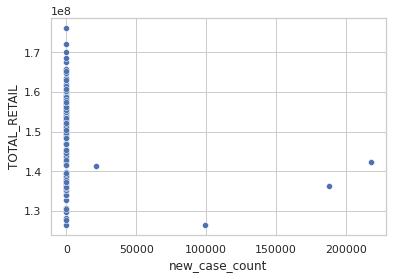

In [55]:
sns.set(style='whitegrid')

sns.scatterplot(x="new_case_count",
                y="TOTAL_RETAIL",
                data=for_plots)

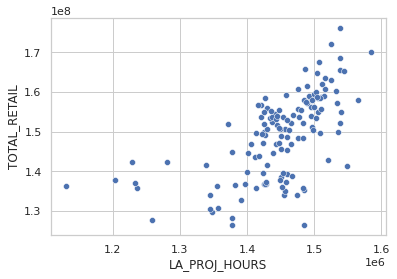

In [56]:
sns.set(style='whitegrid')

sns.scatterplot(x="LA_PROJ_HOURS",
                y="TOTAL_RETAIL",
                data=for_plots)

In [57]:
X_train.head()

,FISCAL_YEAR,FISCAL_WEEK,WEEK_START_DATE,FISCAL_QUARTER,LA_PROJ_HOURS,LA_AUTOZONERS,LA_TRUCK_HOURS,LA_TASK_HOURS,SUM_SCAN_COUNT,max_temp,avg_temp,max_prcp,max_wspd,Email_Delivered,Web_Traffic,Retail_FoodServices_Sales,TV_Spend,Radio_Spend,Search_Spend,Others_Spend,BASE_EARNED_NUM,BASE_EARNED_AMT,BONUS_EARNED_NUM,BONUS_EARNED_AMT,ACTIVE_CUSTOMER_NUM,ACTIVE_LOYAL_CUSTOMER_PCT,NEW_CUSTOMER_PCT,ELITE_CUSTOMER_PCT,AMT,LOYALTY_AMT_PCT,ELITE_AMT_PCT,AutoZone_Trend,Handheld_Cnt,Loan_a_Tool,Charger_Cnt,AutoZone_Trend.1,new_case_count,new_death_count,gps_retail_and_recreation,gps_transit_stations,gps_workplaces,gps_residential,gps_away_from_home,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,initclaims_count_regular,contclaims_count_regular,contclaims_count_peuc,initclaims_rate_regular,contclaims_rate_regular,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,initclaims_rate_combined,contclaims_rate_combined
0,2018,1,2017-08-27,1,1421365.93,1162676.25,81648.70,177040.98,239103,119.0,73.695477,26.03,67,6457405,4229486,491564,497159.65,672672.08,71666.03,28148.04,0,0,0,0.0,1575409,0.918212,0.117337,0.098990,1.009856e+08,0.886216,0.148122,23,318053,76028,64498,23,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0
1,2018,2,2017-09-03,1,1429560.42,1158595.50,79323.43,191641.49,254719,113.4,71.231313,2.90,68,6515685,4205683,470724,2810.10,733115.58,196576.44,56514.55,0,0,0,0.0,1588696,0.917590,0.114983,0.098347,1.012665e+08,0.884985,0.145896,22,328730,78265,67448,22,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0
2,2018,3,2017-09-10,1,1424297.21,1153215.32,79539.57,191542.32,247955,110.7,71.538687,10.23,106,6400736,4119128,470724,3362.60,602865.83,221491.70,130368.92,0,0,0,0.0,1512654,0.919119,0.115297,0.100280,9.610760e+07,0.885954,0.149468,21,312493,72921,63239,21,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0
3,2018,4,2017-09-17,1,1464945.93,1150216.00,79117.34,235612.59,250781,103.9,74.631720,7.11,88,6404858,4298083,470724,567358.25,613455.27,233529.37,205006.59,0,0,0,0.0,1529324,0.921267,0.114007,0.100194,9.651156e+07,0.888507,0.150799,21,306898,73939,61215,21,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0
4,2018,5,2017-09-24,1,1425093.29,1150226.77,78145.11,196721.41,259683,103.4,71.613739,5.23,63,6451031,4365563,470724,219272.80,639914.00,261444.09,101397.86,0,0,0,0.0,1553661,0.921017,0.113392,0.100063,9.871133e+07,0.888274,0.151638,21,308575,74819,61664,21,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0


In [58]:
X_train.shape

(136, 63)

***FEATURE SELECTION***


In [59]:
X_train.iloc[:, 4:].head(2)

,LA_PROJ_HOURS,LA_AUTOZONERS,LA_TRUCK_HOURS,LA_TASK_HOURS,SUM_SCAN_COUNT,max_temp,avg_temp,max_prcp,max_wspd,Email_Delivered,Web_Traffic,Retail_FoodServices_Sales,TV_Spend,Radio_Spend,Search_Spend,Others_Spend,BASE_EARNED_NUM,BASE_EARNED_AMT,BONUS_EARNED_NUM,BONUS_EARNED_AMT,ACTIVE_CUSTOMER_NUM,ACTIVE_LOYAL_CUSTOMER_PCT,NEW_CUSTOMER_PCT,ELITE_CUSTOMER_PCT,AMT,LOYALTY_AMT_PCT,ELITE_AMT_PCT,AutoZone_Trend,Handheld_Cnt,Loan_a_Tool,Charger_Cnt,AutoZone_Trend.1,new_case_count,new_death_count,gps_retail_and_recreation,gps_transit_stations,gps_workplaces,gps_residential,gps_away_from_home,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,initclaims_count_regular,contclaims_count_regular,contclaims_count_peuc,initclaims_rate_regular,contclaims_rate_regular,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,initclaims_rate_combined,contclaims_rate_combined
0,1421365.93,1162676.25,81648.70,177040.98,239103,119.0,73.695477,26.03,67,6457405,4229486,491564,497159.65,672672.08,71666.03,28148.04,0,0,0,0.0,1575409,0.918212,0.117337,0.098990,100985558.3,0.886216,0.148122,23,318053,76028,64498,23,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0
1,1429560.42,1158595.50,79323.43,191641.49,254719,113.4,71.231313,2.90,68,6515685,4205683,470724,2810.10,733115.58,196576.44,56514.55,0,0,0,0.0,1588696,0.917590,0.114983,0.098347,101266512.4,0.884985,0.145896,22,328730,78265,67448,22,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0.0,0.0


In [60]:
# Mutual information based on a k-NN strategy is used to measure the information shared between the two time series. 
mi = mutual_info_regression(X_train.iloc[:, 4:], y_train)
cols = X_train.iloc[:, 4:].columns
df=pd.DataFrame(mi, columns = ["MI"], index = cols)
df.sort_values(by = "MI" , ascending = False)

,MI
AMT,0.981275
ACTIVE_CUSTOMER_NUM,0.762579
LA_TRUCK_HOURS,0.561188
ELITE_CUSTOMER_PCT,0.502663
AutoZone_Trend,0.490261
AutoZone_Trend.1,0.471888
max_temp,0.450945
SUM_SCAN_COUNT,0.427029
Retail_FoodServices_Sales,0.415467
LA_PROJ_HOURS,0.382014


In [61]:
df1=df.sort_values(by = "MI", ascending = False).reset_index().head(30)
keep_list = df1["index"].to_list()
keep_list 

['AMT',
 'ACTIVE_CUSTOMER_NUM',
 'LA_TRUCK_HOURS',
 'ELITE_CUSTOMER_PCT ',
 'AutoZone_Trend',
 'AutoZone_Trend.1',
 'max_temp',
 'SUM_SCAN_COUNT',
 'Retail_FoodServices_Sales',
 'LA_PROJ_HOURS',
 'LA_AUTOZONERS',
 'Loan_a_Tool',
 'Email_Delivered',
 'avg_temp',
 'LOYALTY_AMT_PCT ',
 'BASE_EARNED_NUM',
 'BASE_EARNED_AMT',
 'ACTIVE_LOYAL_CUSTOMER_PCT ',
 'NEW_CUSTOMER_PCT ',
 'Charger_Cnt',
 'Web_Traffic',
 'Handheld_Cnt',
 'Radio_Spend',
 'Search_Spend',
 'Others_Spend',
 'max_wspd',
 'BONUS_EARNED_AMT',
 'BONUS_EARNED_NUM',
 'max_prcp',
 'ELITE_AMT_PCT ']

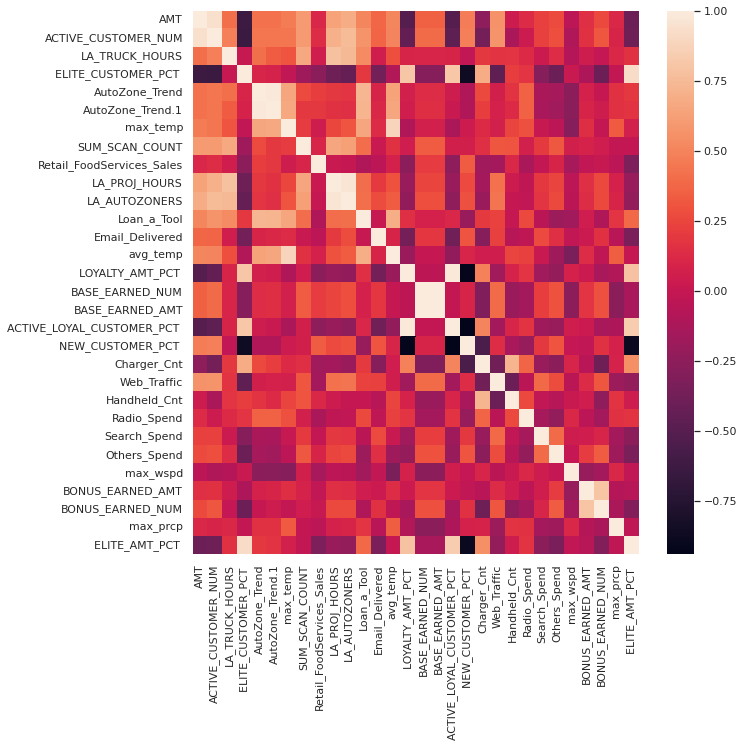

In [62]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
corr = X_train[keep_list].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [63]:
keep_list_final= ['AMT',
#  'ACTIVE_CUSTOMER_NUM',
 'LA_TRUCK_HOURS',
 'ELITE_CUSTOMER_PCT ',
#  'AutoZone_Trend',
 'AutoZone_Trend.1',
#  'max_temp',
 'SUM_SCAN_COUNT',
 'Retail_FoodServices_Sales',
#  'LA_PROJ_HOURS',
#  'LA_AUTOZONERS',
 'Loan_a_Tool',
 'Email_Delivered',
 'avg_temp',
 'LOYALTY_AMT_PCT ',
#  'BASE_EARNED_NUM',
 'BASE_EARNED_AMT',
#  'ACTIVE_LOYAL_CUSTOMER_PCT ',
 'NEW_CUSTOMER_PCT ',
 'Charger_Cnt',
 'Web_Traffic',
 'Handheld_Cnt',
 'Radio_Spend',
 'Search_Spend',
 'Others_Spend',
 'max_wspd',
 'BONUS_EARNED_AMT',
#  'BONUS_EARNED_NUM',
 'max_prcp',
#  'ELITE_AMT_PCT '
 ]
len(keep_list_final)

21

In [64]:
xscaler = MinMaxScaler() #not outlier sensitive as comapred to Standard Scaler
yscaler = MinMaxScaler()

xscaler.fit(X_train.loc[:, keep_list_final])
yscaler.fit(y_train)

X_scaled_tr = xscaler.transform(X_train.loc[:, keep_list_final])
y_scaled_tr = yscaler.transform(y_train)

pd.DataFrame(X_scaled_tr).head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.338183,0.924867,0.851752,0.636364,0.500240,0.448637,0.651564,0.397195,0.859948,0.0,0.589182,0.388394,0.611870,0.122561,0.660092,0.610533,0.000000,0.000000,0.400000,0.0,1.000000
1,0.343561,0.898138,0.824551,0.545455,0.585416,0.333521,0.704024,0.400836,0.813798,0.0,0.583308,0.361150,0.682728,0.108454,0.708872,0.685183,0.216011,0.046144,0.415385,0.0,0.055918


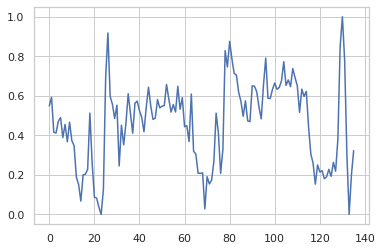

In [65]:
plt.plot(y_scaled_tr)

In [66]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [67]:
hist_window = 24
horizon = 12
TRAIN_SPLIT = 80
x_input_tr, y_input_tr = custom_ts_multi_data_prep(X_scaled_tr, y_scaled_tr, 0, TRAIN_SPLIT, hist_window, horizon)
x_input_val, y_input_val = custom_ts_multi_data_prep(X_scaled_tr, y_scaled_tr,TRAIN_SPLIT, None,hist_window, horizon)

In [68]:
# reshape input to be 3D [samples, timesteps, features]
x_input_tr.shape, y_input_tr.shape, x_input_val.shape, y_input_val.shape

((56, 24, 21), (56, 12, 1), (20, 24, 21), (20, 12, 1))

In [79]:
batch_size = 64
buffer_size = 50

train_data = tf.data.Dataset.from_tensor_slices((x_input_tr, y_input_tr))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_input_val, y_input_val))
val_data = val_data.batch(batch_size).repeat()

In [80]:
x_input_tr.shape[-2:]

(24, 21)

In [97]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), input_shape=x_input_tr.shape[-2:]),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(units=horizon, activation = 'relu')
])
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
lstm_model.compile(optimizer=opt, loss='mse')

In [98]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 24, 400)          355200    
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 24, 32)            12832     
                                                                 
 batch_normalization_8 (Batc  (None, 24, 32)           128       
 hNormalization)                                                 
                                                                 
 bidirectional_9 (Bidirectio  (None, 200)              106400    
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 200)               0         
                                                      

In [99]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

In [100]:
history = lstm_model.fit(train_data,epochs=30,steps_per_epoch=10,validation_data=val_data,validation_steps=5,verbose=1,callbacks=callbacks)

Epoch 1/30
10/10 [==============================] - 16s 659ms/step - loss: 0.3000 - val_loss: 0.1778
Epoch 2/30
10/10 [==============================] - 3s 266ms/step - loss: 0.2278 - val_loss: 0.1771
Epoch 3/30
10/10 [==============================] - 3s 260ms/step - loss: 0.2037 - val_loss: 0.1724
Epoch 4/30
10/10 [==============================] - 3s 265ms/step - loss: 0.1978 - val_loss: 0.1653
Epoch 5/30
10/10 [==============================] - 3s 256ms/step - loss: 0.1901 - val_loss: 0.1586
Epoch 6/30
10/10 [==============================] - 3s 265ms/step - loss: 0.1826 - val_loss: 0.1527
Epoch 7/30
10/10 [==============================] - 3s 267ms/step - loss: 0.1831 - val_loss: 0.1476
Epoch 8/30
10/10 [==============================] - 3s 261ms/step - loss: 0.1814 - val_loss: 0.1413
Epoch 9/30
10/10 [==============================] - 3s 264ms/step - loss: 0.1793 - val_loss: 0.1363
Epoch 10/30
10/10 [==============================] - 3s 262ms/step - loss: 0.1742 - val_loss: 0.133

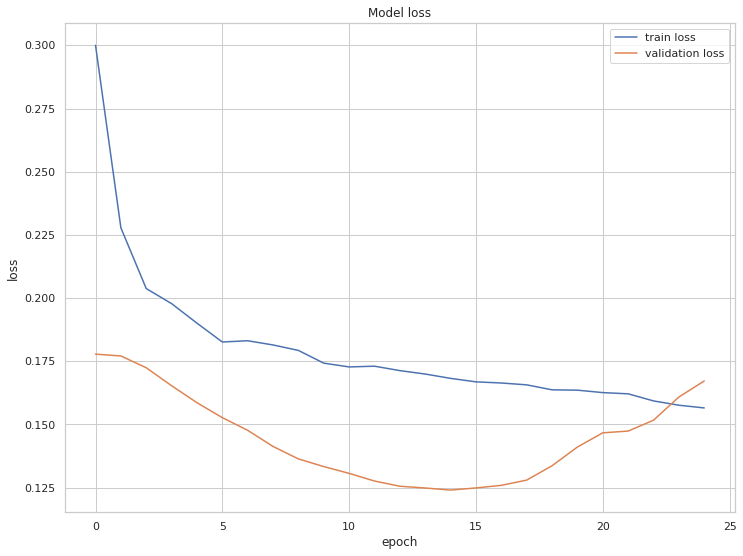

In [101]:
plt.figure(figsize=(12,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

*PREDICTIONS*

In [102]:
X_test = pd.DataFrame(X_scaled_tr).tail(24)

In [103]:
xtest = X_test.to_numpy().reshape((1,24,21))
pred = lstm_model.predict(xtest)
pred, pred.shape

1/1 [==============================] - 2s 2s/step


(array([[0.        , 0.        , 0.7909485 , 0.        , 0.7879634 ,
         0.3269249 , 1.0985372 , 0.30540523, 0.5969666 , 0.61208934,
         0.        , 0.18333834]], dtype=float32), (1, 12))

In [104]:
pred_Inverse = yscaler.inverse_transform(pred) #pred from model
pred_Inverse.shape
pd.DataFrame(pred_Inverse).T

,0
0,126404216.0
1,126404216.0
2,165793456.0
3,126404216.0
4,165644784.0
5,142685072.0
6,181111360.0
7,141613392.0
8,156133152.0
9,156886256.0
